# lorapy symbol viewer

In [71]:
%load_ext autoreload
%autoreload 2

import pathlib

import os, sys
from loguru import logger
logger.remove(None)
logger.add(sys.stdout, colorize=True)

import numpy as np
import pandas as pd
from six.moves import cPickle
import tqdm
from tqdm import tqdm_notebook
import warnings 
import scipy.signal as spsig
import multiprocessing
from functools import partial 

import matplotlib.pyplot as plt 
# plt.style.use('dark_background')
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import lorapy

## setup 

In [3]:
_BASE_DATA_DIR = pathlib.Path('../data')

BENCHTOP_DATA_DIR = _BASE_DATA_DIR.joinpath('lora-benchtop-recording')
DOTP_DATA_DIR = _BASE_DATA_DIR.joinpath('symbol-ref')
DEV_DATA_DIR = _BASE_DATA_DIR.joinpath('dev-data')
PROC_SYMBOL_DIR = _BASE_DATA_DIR.joinpath('processed-symbols')
FILT_SYMBOL_DIR = _BASE_DATA_DIR.joinpath('filtered-symbols')

# load

In [4]:
import random
import warnings 

rand = lambda mx: random.randint(0, mx - 1)

def _load_matching_dotp(bw: int, sf: int):
    return ploader.filter(bw=bw, sf=sf)[0]


def _plot_check(filtered_syms, num=20):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        fig, ax = plt.subplots(num, figsize=(14, 10))

        for idx in range(num):
            ax[idx].plot(filtered_syms[rand(filtered_syms.shape[0])])
            
            
def _format_output_path(out_dir, file):    
    out_path = out_dir.joinpath(file.name)
    return out_path


def _save_symbols(data, out_dir, file):
    out_path = _format_output_path(out_dir, file)
    
    with out_path.open('wb') as outfile:
        cPickle.dump(data, outfile)

## files

In [5]:
symloader = lorapy.load_dotp(PROC_SYMBOL_DIR)
symloader.file_list

2020-04-10 21:32:01.556 | DEBUG    | lorapy.io._base_loader:_validate_data_path:140 - set datafile directory: ../data/processed-symbols
2020-04-10 21:32:01.562 | INFO     | lorapy.io._base_loader:_process_data_dir:153 - found 106 data file(s)


[DotPFile(id=0 | name='lora_BW1_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=1 | name='lora_BW2_SF12_915MHz_20ksps_Att40_v0.p'),
 DotPFile(id=2 | name='lora_BW8_SF12_915MHz_20ksps_Att120_v0.p'),
 DotPFile(id=3 | name='lora_BW1_SF10_915MHz_20ksps_Att140_v0.p'),
 DotPFile(id=4 | name='lora_BW1_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=5 | name='lora_BW1_SF12_915MHz_20ksps_Att60_v0.p'),
 DotPFile(id=6 | name='lora_BW7_SF10_915MHz_20ksps_Att40_v0.p'),
 DotPFile(id=7 | name='lora_BW2_SF10_915MHz_20ksps_Att40_v0.p'),
 DotPFile(id=8 | name='lora_BW9_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=9 | name='lora_BW2_SF12_915MHz_20ksps_Att60_v0.p'),
 DotPFile(id=10 | name='lora_BW2_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=11 | name='lora_BW9_SF11_915MHz_20ksps_Att100_v0.p'),
 DotPFile(id=12 | name='lora_BW7_SF10_915MHz_20ksps_Att100_v0.p'),
 DotPFile(id=13 | name='lora_BW1_SF10_915MHz_20ksps_Att40_v0.p'),
 DotPFile(id=14 | name='lora_BW7_SF11_915MHz_20ksps_Att80_v0.p'),
 DotPFile(id=15 | na

In [6]:
ploader = lorapy.load_dotp(DOTP_DATA_DIR)
ploader.file_list

2020-04-10 21:32:01.586 | DEBUG    | lorapy.io._base_loader:_validate_data_path:140 - set datafile directory: ../data/symbol-ref
2020-04-10 21:32:01.588 | INFO     | lorapy.io._base_loader:_process_data_dir:153 - found 15 data file(s)


[DotPFile(id=0 | name='lora_BW1_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=1 | name='lora_BW1_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=2 | name='lora_BW9_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=3 | name='lora_BW2_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=4 | name='lora_BW9_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=5 | name='lora_BW2_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=6 | name='lora_BW8_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=7 | name='lora_BW7_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=8 | name='lora_BW8_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=9 | name='lora_BW8_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=10 | name='lora_BW1_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=11 | name='lora_BW2_SF11_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=12 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=13 | name='lora_BW7_SF12_915MHz_20ksps_Att0_v0.p'),
 DotPFile(id=14 | name='lora_BW7_SF11_915MHz_20ksps_Att0_v0.p')]

## symbols

In [47]:
file = symloader.select(101)
file.load()
display(file)

pfile = _load_matching_dotp(file.bw, file.sf)
display(pfile)

base_symbol = pfile.to_signal()
display(base_symbol)

symbols = file.to_signal()
display(symbols)

2020-04-10 21:44:58.760 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-10 21:44:59.126 | INFO     | lorapy.datafile._base_file:load:61 - loaded 5514951 samples from file


DotPFile(id=101 | name='lora_BW8_SF11_915MHz_20ksps_Att100_v0.p')

DotPFile(id=8 | name='lora_BW8_SF11_915MHz_20ksps_Att0_v0.p')

2020-04-10 21:44:59.131 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-10 21:44:59.133 | INFO     | lorapy.datafile._base_file:load:61 - loaded 1599 samples from file


BaselineSymbolSet(num symbols=1599 | BW: 8 | SF: 11 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

BaselineSymbolSet(num symbols=3449 | BW: 8 | SF: 11 | Att: 100 | samples per symbol: 1599 | packet length: 48369)

# symbol filtering

In [94]:
def _fft_convolve_autocorr(symbol: np.ndarray):
    return spsig.fftconvolve(symbol, symbol[::-1], mode='full')

def _sp_corr(base_symbol: np.ndarray, packet_slice: np.ndarray) -> float:
    min_size = np.min((base_symbol.size, packet_slice.size))
    corr = spsig.correlate(base_symbol, packet_slice)
    return np.abs(corr.max())
    
def _compute_corr(symbol: np.ndarray, base_symbol: np.ndarray) -> float:
    return _sp_corr(base_symbol, _fft_convolve_autocorr(symbol))

def _mp_compute_corr(base_sym: np.ndarray, symbols: np.ndarray) -> np.ndarray:
    logger.warning(f'beginning multiprocessing..')
    _part_compute_corr = partial(_compute_corr, base_symbol=base_sym)    

    with multiprocessing.Pool() as pool:
        results = pool.map(_part_compute_corr, symbols)
    
    logger.warning(f'completed multiprocessing')
    return np.vstack(results)
    

def filter_symbols_fftcorr(file, thresh_adj=0.4, mp=True, plot=False):
    symbols = file.to_signal()
    display(symbols)

    pfile = _load_matching_dotp(file.bw, file.sf)
    base_symbol = pfile.to_signal()
    display(base_symbol)
    
    if mp:
        corr_fftconvs = _mp_compute_corr(base_symbol.data, symbols.data)
    else:    
        corr_fftconvs = np.vstack([
            _compute_corr(sym, base_symbol.data)
            for sym in symbols.data
        ])
    
    thresh = corr_fftconvs.mean() 
    thresh *= thresh_adj
    logger.info(f'set threshold: {thresh:0.6f}')
    
    filtered_symbols = symbols.data[np.where(corr_fftconvs > thresh)]
    _rm_symbols = symbols.data[np.where(corr_fftconvs < thresh)]
   
    _removed_syms = symbols.data.shape[0] - len(filtered_symbols)
    logger.warning(f'removed {_removed_syms} symbols  [{len(filtered_symbols)} / {symbols.data.shape[0]}]')
    
    if plot:
        _plot_check(filtered_symbols, 40)
        
    return filtered_symbols, _rm_symbols, corr_fftconvs

In [ ]:
for file in tqdm.notebook.tqdm(symloader.file_list):
    logger.warning(f'working file {file}')
    file.load()
    if file.bw > 6 and file.att > 100:
        continue
    
    filtered_symbols = filter_symbols(file, thresh_type='quant', plot=False)
    _save_symbols(filtered_symbols, FILT_SYMBOL_DIR, file)
    

# additional filtering

In [89]:
file.name

'lora_BW8_SF11_915MHz_20ksps_Att100_v0.p'

## new fft autocorr

In [95]:
%%time
THRESH_ADJ = 0.4

filtered_symbols, _rm_symbols, corr_fftconvs = filter_symbols_fftcorr(file, thresh_adj=THRESH_ADJ, mp=True, plot=False)

BaselineSymbolSet(num symbols=3449 | BW: 8 | SF: 11 | Att: 100 | samples per symbol: 1599 | packet length: 48369)

2020-04-10 22:22:48.593 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 1599 and packet length: 48369
2020-04-10 22:22:48.594 | INFO     | lorapy.datafile._base_file:load:61 - loaded 1599 samples from file


BaselineSymbolSet(num symbols=1599 | BW: 8 | SF: 11 | Att: 0 | samples per symbol: 1599 | packet length: 48369)

2020-04-10 22:22:48.597 | WARNING  | __main__:_mp_compute_corr:13 - beginning multiprocessing..
2020-04-10 22:22:50.650 | WARNING  | __main__:_mp_compute_corr:19 - completed multiprocessing
2020-04-10 22:22:50.665 | INFO     | __main__:filter_symbols_fftcorr:41 - set threshold: 0.000045
2020-04-10 22:22:50.667 | WARNING  | __main__:filter_symbols_fftcorr:47 - removed 82 symbols  [3367 / 3449]
CPU times: user 196 ms, sys: 328 ms, total: 524 ms
Wall time: 2.08 s


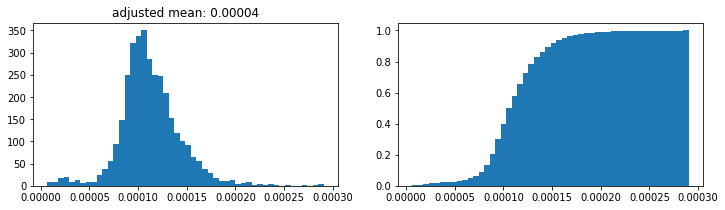

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax[0].hist(corr_fftconvs, bins=50)
    ax[1].hist(corr_fftconvs, bins=50, cumulative=True, density=True)
    ax[0].set_title(f'adjusted mean: {corr_fftconvs.mean() * THRESH_ADJ:0.5f}')


# visualize

batches = 4


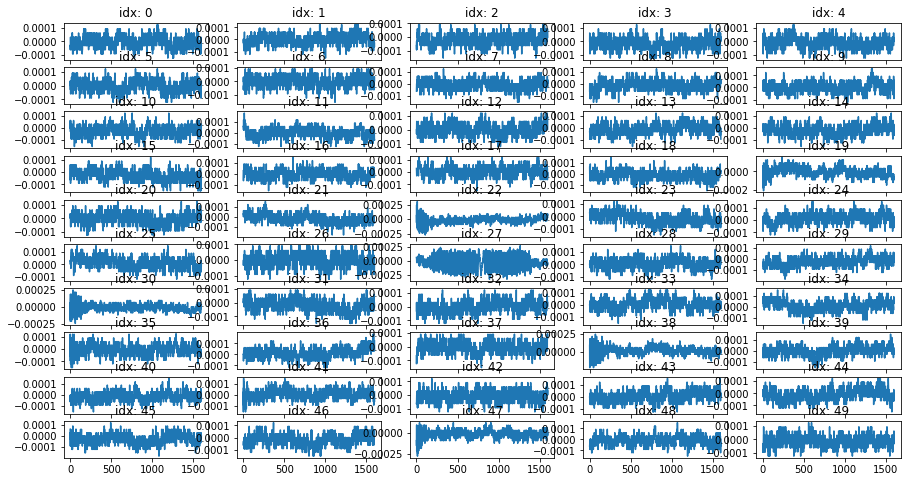

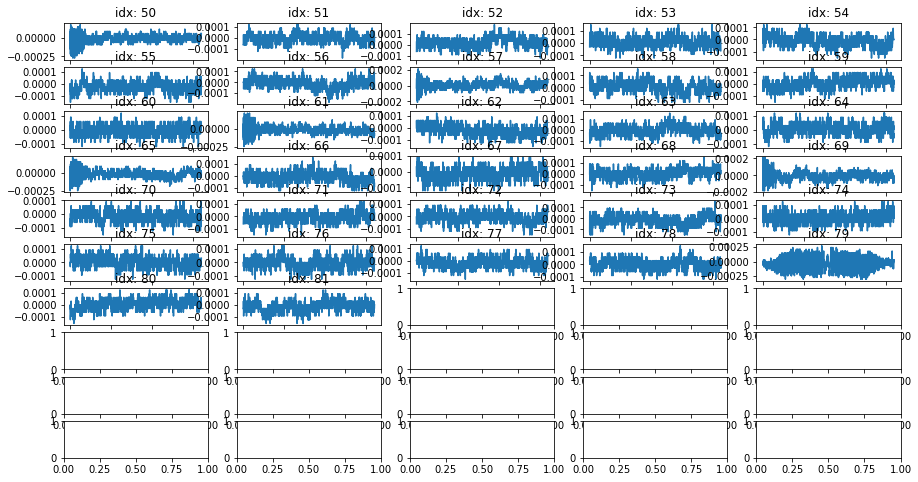

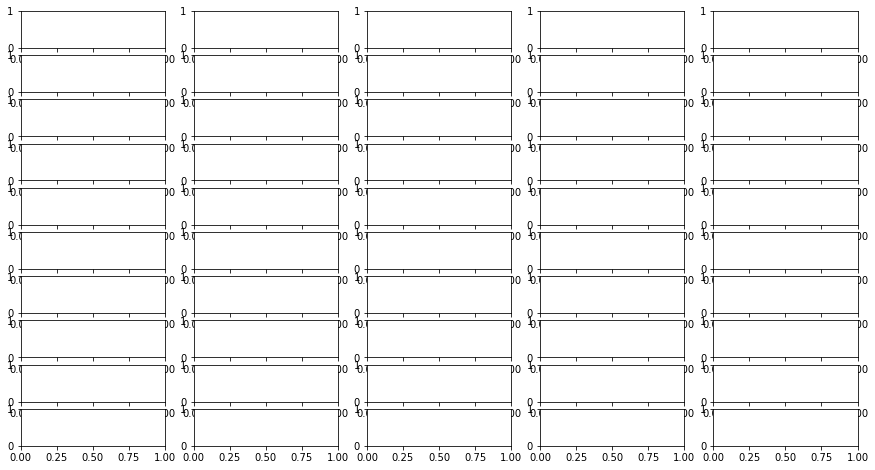

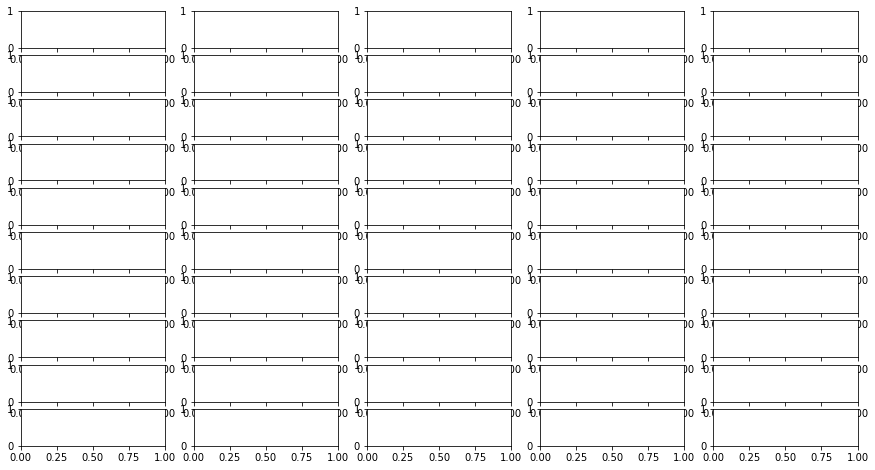

In [66]:
tar_symbols = _rm_symbols
# tar_symbols = filtered_symbols

batch_size, stop_limit = 20, 8
batches = len(tar_symbols) // batch_size
print(f'batches = {batches}')

stop = 0

for epoch in range(len(tar_symbols) // batch_size):
    rows, cols = 10, 5
    fig, ax = plt.subplots(10, 5, figsize=(15, 8))
    
    for i in range(rows):
        for j in range(cols):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                idx = (epoch * rows * cols) + (cols * i) + j 
                if idx >= len(tar_symbols):
                    break
                ax[i, j].plot(tar_symbols[idx])
                ax[i, j].set_title(f'idx: {idx}')
            
    stop += 1
    if stop > stop_limit:
        break
    

# old dev

## setup

In [ ]:
file = symloader.filter(bw=9, sf=11, att=40)[0]
display(file)
file.load()

pfile = _load_matching_dotp(file.bw, file.sf)
display(pfile)

base_symbol = pfile.to_signal()
display(base_symbol)

In [ ]:
filtered_symbols, conv_vals = filter_symbols(file, thresh_type='quant', plot=False)

In [ ]:
bad_symbols = np.vstack([
    filtered_symbols[15],
    filtered_symbols[16],
    filtered_symbols[20],
    filtered_symbols[99],
    filtered_symbols[100],
    filtered_symbols[101],
    filtered_symbols[110],
    filtered_symbols[111],
])

good_symbols = np.vstack([
    filtered_symbols[0],
    filtered_symbols[5],
    filtered_symbols[8],
    filtered_symbols[71],
    filtered_symbols[1],
    filtered_symbols[3],
    filtered_symbols[29],
    filtered_symbols[30],
])

In [ ]:
plt.plot(conv_vals)

## bad symbol location

In [ ]:
for sym in filtered_symbols[10:20]:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        plt.figure(figsize=(5,1))
        plt.plot(sym)

In [ ]:
sym_df = (
    pd.DataFrame({'good': good_symbol, 'bad': bad_symbol})
    .assign(
        good_abs = lambda df: np.abs(df.good),
        bad_abs = lambda df: np.abs(df.bad),
    )
)
sym_df.head()

## metric exploration

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax[0].plot(good_symbols[0])
    ax[1].plot(bad_symbols[1])

## convolution

In [ ]:
import scipy as sp
import scipy.stats as spstats
import scipy.signal as spsig

In [ ]:
def _fft_convolve_autocorr(symbol: np.ndarray):
    return spsig.fftconvolve(symbol, symbol[::-1], mode='full')

def _sp_corr(base_symbol: np.ndarray, packet_slice: np.ndarray) -> float:
    min_size = np.min((base_symbol.size, packet_slice.size))
    corr = spsig.correlate(base_symbol, packet_slice)
    return np.abs(corr.max())
    

In [ ]:
good_fftconvs = np.vstack([
    _fft_convolve_autocorr(sym)
    for sym in good_symbols
])

bad_fftconvs = np.vstack([
    _fft_convolve_autocorr(sym)
    for sym in bad_symbols
])

In [ ]:
corr_vals = np.array([
    _sp_corr(base_symbol.data, fftconv)
    for fftconv in np.vstack([good_fftconvs, bad_fftconvs])
])

In [ ]:
_fftconvs = np.vstack([
    _sp_corr(base_symbol.data, _fft_convolve_autocorr(sym))
    for sym in np.vstack([good_symbols, bad_symbols])
])

In [ ]:
corr_vals = np.array([
    _sp_corr(base_symbol.data, fftconv)
    for fftconv in np.vstack([good_fftconvs, bad_fftconvs])
])

In [ ]:
plt.plot(sorted(corr_vals))

In [ ]:
filtered_symbols = [
    sym for sym, corr in zip(np.vstack([good_symbols,bad_symbols]), corr_vals)
    if corr > corr_vals.mean()
]

In [ ]:
len(filtered_symbols)

In [ ]:
idx = 0

In [ ]:
logger.warning(f'\n idx = {idx} '.center(60, '='))

good_fft_corr = _compute_corrcoefs(base_symbol.data, good_fftconvs[idx])
bad_fft_corr = _compute_corrcoefs(base_symbol.data, bad_fftconvs[idx])
good_sp_corr = _sp_corr(base_symbol.data, good_fftconvs[idx])
bad_sp_corr = _sp_corr(base_symbol.data, bad_fftconvs[idx])


fig, ax = plt.subplots(2, 2, figsize=(12, 6))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax[0,0].plot(good_symbols[idx])
    ax[0,1].plot(bad_symbols[idx])
    ax[1,0].plot(good_fftconvs[idx])
    ax[1,0].set_xlabel(f'good corr: {good_sp_corr:0.6f}')
    ax[1,1].plot(bad_fftconvs[idx])
    ax[1,1].set_xlabel(f'bad corr: {bad_sp_corr:0.6f}')
    

idx += 1

## correlation

In [ ]:
def _compute_corrcoefs(base_symbol: np.ndarray, packet_slice: np.ndarray) -> float:
    min_size = np.min((base_symbol.size, packet_slice.size))

    return np.real(np.abs(
        np.corrcoef(base_symbol[:min_size], packet_slice[:min_size])[0, 1]
    ))

In [ ]:
def _sp_corr(base_symbol: np.ndarray, packet_slice: np.ndarray) -> float:
    min_size = np.min((base_symbol.size, packet_slice.size))
    corr = spsig.correlate(base_symbol, packet_slice)
    return np.abs(corr.max())
    

In [ ]:
good_sp_corr = spsig.correlate(base_symbol.data, good_fftconvs[0])
bad_sp_corr = spsig.correlate(base_symbol.data, bad_fftconvs[0])

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax[0].plot(good_sp_corr)
    ax[1].plot(bad_sp_corr)

In [ ]:
_compute_corrcoefs(base_symbol.data, good_fftconv), _compute_corrcoefs(base_symbol.data, bad_fftconv)